In [1]:
import os
import streamlit as st
from utils import *
from few_shots.few_shots_v2 import few_shots_list_of_dict
from langchain_cohere import ChatCohere
from langchain.prompts import FewShotPromptTemplate, PromptTemplate
from langchain.prompts.example_selector import SemanticSimilarityExampleSelector
from langchain_experimental.sql import SQLDatabaseChain
from langchain_community.utilities.sql_database import SQLDatabase
from langchain.memory import ConversationBufferWindowMemory
from langchain_community.vectorstores import Chroma 
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.chains.sql_database.prompt import PROMPT_SUFFIX

import warnings
warnings.filterwarnings("ignore")


In [2]:
Questions=[f"Question: {example['Question']}" for example in few_shots_list_of_dict]

In [3]:
Questions[0]

'Question: How many t-shirts do we have LEFT for Nike in XS size AND white color?'

In [4]:
def removes_spaces(s) -> str:
    s=s.split("\n")
    #print(s)
    return " ".join([ele.strip() for ele in s if ele])

SQLQuery=[example['SQLQuery'] for example in few_shots_list_of_dict]

In [5]:
SQLQuery=[f"Question: {query}" for query in map(removes_spaces,SQLQuery)]
SQLQuery[2]

"Question: SELECT SUM(a.total_amount * ((100-COALESCE(discounts.discount_percent,0))/100)) as total_revenue FROM(select SUM(price*stock) as total_amount, tshirt_id FROM tshirt_inventory WHERE brand='LEVI' GROUP BY tshirt_id) a LEFT join discounts ON a.tshirt_id=discounts.tshirt_id"

In [6]:
from typing import *
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages

In [7]:
# Load environment variables
from dotenv import load_dotenv
load_dotenv()

db_user = os.getenv("USER")
db_password = os.getenv("PASSWORD")
db_host = os.getenv("HOST")
db_name = os.getenv("NAME")

In [4]:
os.environ["COHERE_API_KEY"]=os.getenv("COHERE_API_KEY")        # Set the cohere api key
os.environ["LANGCHAIN_TRACING_V2"]="true"                       # Enable tracing
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")  # Set the project name

In [86]:
try:
    db = SQLDatabase.from_uri(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}",sample_rows_in_table_info=5)
    print("Successfully connected to the database!")
except:
    print("Failed to connect to the database. Please check your credentials.")

Successfully connected to the database!


In [6]:
embeddings = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2", model_kwargs={'device': 'cuda'})
to_vectorize = [" ".join(example.values()) for example in few_shots_list_of_dict]
vectorstore = Chroma.from_texts(
    to_vectorize, 
    embeddings, 
    metadatas=few_shots_list_of_dict, 
    ids=[str(i) for i in range(len(to_vectorize))],  # Ensure unique IDs
    persist_directory="./chromadb"
)
# Example selector using semantic similarity
example_selector = SemanticSimilarityExampleSelector(vectorstore=vectorstore, k=3)

In [7]:
mysql_prompt = """You are a MySQL Expert and T-shirt inventory manager. Given an input question, first create a syntactically correct MySQL query to run. 
Query for at most 5 results using the LIMIT clause, unless the user specifies. You must query only the columns that are needed to answer the question.
Pay attention to use only the column names you see in the tables, Only query for columns that exist in the table. Also, pay close attention to which column is in which table.

# Use the below format:

# Question: Question here
# SQLQuery: Query to run with no pre-amble

"""

example_prompt = PromptTemplate(
    input_variables=["Question", "SQLQuery"],
    template="\nQuestion: {Question}\nSQLQuery: {SQLQuery}\n",
)

few_shot_prompt = FewShotPromptTemplate(
    example_selector=example_selector,  # assumed defined earlier
    example_prompt=example_prompt,
    prefix=mysql_prompt,
    suffix=PROMPT_SUFFIX,  # assumed defined earlier
    input_variables=["Question", "SQLQuery"],
)

#memory = ConversationBufferWindowMemory(k=10, return_messages=True)


llm = ChatCohere(model="command-a-03-2025")  # your model

chatbot = SQLDatabaseChain.from_llm(
    llm=llm,
    db=db,
    #memory=memory,
    prompt=few_shot_prompt,
    return_sql=True
)

In [8]:
def clean_sql_query(query):
    return query.replace("```sql", "").replace("```", "").replace("`","").strip()

In [9]:
response = chatbot.invoke("How many t-shirts do we have left for adidas in XS size and white color?")
print(response)

{'query': 'How many t-shirts do we have left for adidas in XS size and white color?', 'result': "```sql\nSELECT SUM(stock_quantity) AS remaining_stock\nFROM t_shirts\nWHERE brand = 'Adidas' AND size = 'XS' AND color = 'White';\n```"}


In [10]:
out=clean_sql_query(response['result'])
print(out)

SELECT SUM(stock_quantity) AS remaining_stock
FROM t_shirts
WHERE brand = 'Adidas' AND size = 'XS' AND color = 'White';


In [11]:
class State(TypedDict):
    messages:Annotated[list,add_messages]    

In [12]:
from langchain.schema import AIMessage

def query_generator(state: State):
    # get message content wrapped in HumanMessage object
    raw_input = state["messages"][0].content

    # print(state["messages"])
    # print(type(state["messages"]))
    # print(type(state["messages"][0]))

    result = chatbot.invoke({"query": raw_input})  # or use correct input key
    
    return {"messages": [AIMessage(content=result["result"])]}
    

builder=StateGraph(State)  
builder.add_node("query_generator", query_generator)
builder.add_edge(START, "query_generator")


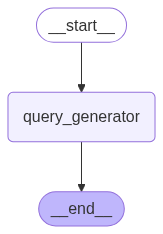

In [13]:
graph=builder.compile()
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
out=graph.invoke({"messages":"how many colors are available?"})

In [15]:
print(out)

{'messages': [HumanMessage(content='how many colors are available?', additional_kwargs={}, response_metadata={}, id='12447646-95e9-4f3f-af12-0631f177a289'), AIMessage(content='```sql\nSELECT COUNT(DISTINCT color) AS available_colors\nFROM t_shirts\nLIMIT 1;\n```', additional_kwargs={}, response_metadata={}, id='68de640f-5e1f-4ca2-8698-eae06d72e161')]}


In [16]:
query=clean_sql_query(out['messages'][1].content)

In [17]:
print(query)

SELECT COUNT(DISTINCT color) AS available_colors
FROM t_shirts
LIMIT 1;


In [42]:
SQLQuery[2][10:]

"SELECT SUM(a.total_amount * ((100-COALESCE(discounts.DISCOUNT_PERCENT,0))/100)) as total_revenue FROM(select SUM(PRICE*STOCK_QUANTITY) as total_amount, TSHIRT_ID FROM tshirt_inventory WHERE BRAND = 'LEVI' GROUP BY TSHIRT_ID) a LEFT join discounts ON a.TSHIRT_ID = discounts.TSHIRT_ID"

In [8]:
import psycopg2
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Fetch variables
USER = os.getenv("SUPABASE_user")
PASSWORD = os.getenv("SUPABASE_password")
HOST = os.getenv("SUPABASE_host")
PORT = os.getenv("SUPABASE_port")
DBNAME = os.getenv("SUPABASE_dbname")

# Connect to the database
try:
    connection = psycopg2.connect(
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT,
        dbname=DBNAME
    )
    print("Connection successful!")
except Exception as e:
    print(f"Failed to connect: {e}")

Connection successful!


In [9]:
# Create a cursor to execute SQL queries
cursor = connection.cursor()
# Example query
cursor.execute(SQLQuery[2][10:])
result = cursor.fetchone()
print(result)

(Decimal('1318755'),)


In [10]:
# Close the cursor and connection
cursor.close()
connection.close()
print("Connection closed.")

Connection closed.


In [7]:
db = SQLDatabase.from_uri(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}",sample_rows_in_table_info=5)
print("Successfully connected to the database!")

Successfully connected to the database!


In [16]:
embeddings = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2", model_kwargs={'device': 'cuda'})
to_vectorize = [" ".join(example.values()) for example in few_shots_list_of_dict]
vectorstore = Chroma.from_texts(
    to_vectorize, 
    embeddings, 
    metadatas=few_shots_list_of_dict, 
    ids=[str(i) for i in range(len(to_vectorize))],  # Ensure unique IDs
    persist_directory="./chromadb"
)

In [17]:
vectorstore.get(ids='2')

{'ids': ['2'],
 'embeddings': None,
 'documents': ["If we have to sell all the Levi’s T-shirts today with discounts applied. How much revenue  our store will generate post discounts? SELECT SUM(a.total_amount * ((100-COALESCE(discounts.DISCOUNT_PERCENT,0))/100)) as total_revenue \n                      FROM(select SUM(PRICE*STOCK_QUANTITY) as total_amount, TSHIRT_ID \n                      FROM tshirt_inventory WHERE BRAND = 'LEVI' GROUP BY TSHIRT_ID) a \n                      LEFT join discounts ON a.TSHIRT_ID = discounts.TSHIRT_ID"],
 'uris': None,
 'included': ['metadatas', 'documents'],
 'data': None,
 'metadatas': [{'Question': 'If we have to sell all the Levi’s T-shirts today with discounts applied. How much revenue  our store will generate post discounts?',
   'SQLQuery': "SELECT SUM(a.total_amount * ((100-COALESCE(discounts.DISCOUNT_PERCENT,0))/100)) as total_revenue \n                      FROM(select SUM(PRICE*STOCK_QUANTITY) as total_amount, TSHIRT_ID \n                     